In [76]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import cluster
from sklearn.decomposition import PCA

from scipy.spatial import distance

In [77]:
##LOADING CLEANED DATA

train = pd.read_csv('train_players_cleaned.csv')
test = pd.read_csv('test_players_cleaned.csv')

#extract player-allstar columns
train_as = train[['Player_year', 'All-Star_caliber']]
test_as = test[['Player_year', 'All-Star_caliber']]

In [78]:
train.head()

,Unnamed: 0,Player_x,Pos_x,Age_x,Tm_x,G_x,GS,MP_x,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ORtg,DRtg,Player_year,Year,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,All-Star_caliber,Abrv,Team_full
0,0,Jordan Adams\adamsjo01,SG,21,MEM,2,0,15,6.9,20.6,0.333,0.0,3.4,0.000,6.9,17.2,0.400,10.3,17.2,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,6.9,24.0,84.0,90,Jordan Adams\adamsjo01/2016,2016,17.3,0.427,0.167,0.833,0.0,15.9,7.6,31.9,10.3,0.0,19.6,30.5,0.0,0.0,0.0,0.015,-2.9,4.8,1.9,0.0,0,MEM,Memphis Grizzlies/2016
1,1,Tony Allen\allento01,SG,34,MEM,64,57,1620,6.8,14.9,0.458,0.5,1.3,0.357,6.4,13.6,0.468,2.9,4.4,0.652,3.3,6.1,9.4,2.2,3.5,0.6,2.5,5.6,17.0,101.0,105,Tony Allen\allento01/2016,2016,12.9,0.505,0.090,0.294,7.0,14.1,10.4,6.9,3.5,1.0,12.8,16.8,0.5,1.9,2.4,0.072,-1.5,1.4,-0.1,0.8,0,MEM,Memphis Grizzlies/2016
2,2,Vince Carter\cartevi01,SG,39,MEM,60,3,1005,6.8,17.6,0.388,3.0,8.7,0.349,3.8,8.9,0.425,3.6,4.3,0.833,1.6,5.9,7.5,2.9,1.9,0.8,1.8,5.2,20.2,107.0,108,Vince Carter\cartevi01/2016,2016,12.7,0.520,0.493,0.245,3.4,13.6,8.3,8.9,1.9,1.5,8.4,18.5,1.0,0.8,1.8,0.084,-0.1,-1.2,-1.2,0.2,0,MEM,Memphis Grizzlies/2016
3,3,Mike Conley\conlemi01,PG,28,MEM,56,56,1761,8.6,20.3,0.422,2.3,6.3,0.363,6.3,14.1,0.449,5.6,6.7,0.834,0.8,4.0,4.8,10.0,2.0,0.5,2.5,2.9,25.0,115.0,110,Mike Conley\conlemi01/2016,2016,19.4,0.538,0.309,0.329,1.6,9.3,5.3,32.7,2.0,0.8,9.5,22.4,4.2,1.1,5.3,0.145,3.7,-1.9,1.7,1.7,0,MEM,Memphis Grizzlies/2016
4,4,Jordan Farmar\farmajo01,PG,29,MEM,12,10,291,7.4,17.7,0.420,2.8,8.0,0.356,4.6,9.7,0.473,1.8,1.8,1.000,0.7,3.7,4.4,6.5,2.7,0.4,3.2,3.9,19.5,103.0,109,Jordan Farmar\farmajo01/2016,2016,13.2,0.527,0.450,0.100,1.5,8.6,4.9,20.6,2.7,0.6,14.7,18.9,0.2,0.2,0.4,0.064,0.2,-1.4,-1.2,0.1,0,MEM,Memphis Grizzlies/2016


In [86]:
#FEATURE SELECTION

#DROP FEATURES THAT ARE RELATED TO PLAYER SUCCESS
## as_caliber, VORP, BPM, WS/48, WS, GS G_x, MP_x 

#FINAL FEATURE SELECTION ***********************
#MIX drop raw and percent metrics 
#keep OBMP DBPM, DROP TOV TOV%, keep ORD DRB TRB AST STL BLK - drop respective %, 
#                drop PTS so stars and high scorers and such won't get clustered together
#                replace FG% with TS%
train_select = train.drop(['Unnamed: 0','Age_x', 'FG','FGA','FG%','3P','3PA','2P','2PA','FT','FTA', 'PTS', 'ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV','TOV%','PER','All-Star_caliber', 'VORP', 'OBPM', 'DBPM', 'BPM', 'WS', 'WS/48', 'USG%', 'GS', 'G_x', 'MP_x'], axis = 1)
test_select = test.drop(['Unnamed: 0','Age_x', 'FG','FGA','FG%','3P','3PA','2P','2PA','FT','FTA', 'PTS', 'ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV','TOV%','PER','All-Star_caliber', 'VORP', 'OBPM', 'DBPM', 'BPM', 'WS', 'WS/48', 'USG%', 'GS', 'G_x', 'MP_x'], axis = 1)

test_select.head()

,Player_x,Pos_x,Tm_x,3P%,2P%,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,ORtg,DRtg,Player_year,Year,TS%,3PAr,FTr,OWS,DWS,Abrv,Team_full
0,Alex Abrines\abrinal01,SG,OKC,0.323,0.500,0.923,0.4,3.4,3.8,1.6,1.3,0.5,4.2,103.0,111,Alex Abrines\abrinal01/2019,2019,0.507,0.809,0.083,0.1,0.6,OKC,Oklahoma City Thunder/2019
1,Steven Adams\adamsst01,C,OKC,0.000,0.596,0.500,6.8,6.5,13.3,2.2,2.0,1.3,3.6,120.0,106,Steven Adams\adamsst01/2019,2019,0.591,0.002,0.361,5.1,4.0,OKC,Oklahoma City Thunder/2019
2,Deonte Burton\burtode02,SG,OKC,0.296,0.455,0.667,0.8,4.7,5.4,1.8,1.2,1.6,6.0,94.0,109,Deonte Burton\burtode02/2019,2019,0.470,0.329,0.146,-0.2,0.3,OKC,Oklahoma City Thunder/2019
3,Tyler Davis\davisty01,C,OKC,0.000,0.000,0.000,46.7,0.0,46.7,0.0,0.0,0.0,0.0,65.0,116,Tyler Davis\davisty01/2019,2019,0.000,0.000,0.000,0.0,0.0,OKC,Oklahoma City Thunder/2019
4,Hamidou Diallo\diallha01,SG,OKC,0.167,0.504,0.610,3.4,5.2,8.6,1.5,1.9,0.9,6.8,103.0,108,Hamidou Diallo\diallha01/2019,2019,0.497,0.145,0.358,0.1,0.7,OKC,Oklahoma City Thunder/2019


In [106]:
##STANDARDIZE DATA FOR LDA
train_standardized  = pd.DataFrame(StandardScaler().fit_transform(train_select.select_dtypes(exclude='object')))
test_standardized  = pd.DataFrame(StandardScaler().fit_transform(test_select.select_dtypes(exclude='object')))

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(n_components=2, solver='svd' )
train_LDA = LDA.fit(train_standardized,train_select['Pos_x']).transform(train_standardized)
train_LDA = pd.DataFrame(train_LDA, columns = ['principal component 1', 'principal component 2' ])

test_LDA = LDA.transform(test_standardized)
test_LDA = pd.DataFrame(test_LDA, columns = ['principal component 1', 'principal component 2' ])

LDA.score(train_standardized,train_select['Pos_x'])


0.6300630063006301

For n_clusters = 2 The average silhouette_score is : 0.47980387092455745
For n_clusters = 3 The average silhouette_score is : 0.48652575276179294
For n_clusters = 4 The average silhouette_score is : 0.41871453865282027
For n_clusters = 5 The average silhouette_score is : 0.38314284114887065
For n_clusters = 6 The average silhouette_score is : 0.3496620672892624
For n_clusters = 7 The average silhouette_score is : 0.35747896389759176
For n_clusters = 8 The average silhouette_score is : 0.3396943606868568
For n_clusters = 9 The average silhouette_score is : 0.3440934944151359


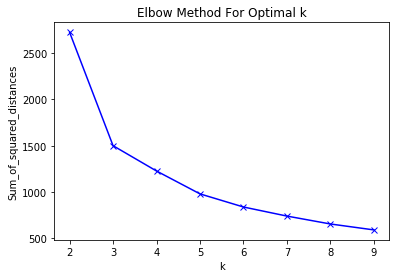

In [107]:
## Number of Cluster Analysis LDA = 2

Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = cluster.KMeans(n_clusters=k)
    km = km.fit(train_LDA)
    Sum_of_squared_distances.append(km.inertia_)
    cluster_labels = km.labels_
    silhouette_avg = silhouette_score(train_LDA, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [108]:
##CLUSTER ANALYSIS

cluster_labels = {4:'Post-Heavy Big Man', 1:'Offensive Big Man', 6:'Pace & Space Forward', 5: 'Defensive Forward', 
                  3: '3 & D Wing', 0: 'Slashing Guard', 7: 'Combo Guard', 2:'Primary Distributing Ballhandler'}

k = 8
kmeans = cluster.KMeans(n_clusters=k, random_state = 1)
kmeans.fit(train_LDA)
train_cluster = kmeans.predict(train_LDA)
test_cluster = kmeans.predict(test_LDA)

train_LDA['Cluster'] = train_cluster
train_LDA['Cluster'] = train_LDA.apply(lambda row: cluster_labels[row.Cluster], axis=1)
train_LDA['Player'] = train_select['Player_year']

train_clustered = train_select.merge(train_LDA, left_on = 'Player_year', right_on = 'Player')
train_clustered = train_clustered.merge(train_as, left_on = 'Player_year', right_on = 'Player_year')
train_clustered = train_clustered.drop(['Player'], axis = 1) 

test_LDA['Cluster'] = test_cluster
test_LDA['Cluster'] = test_LDA.apply(lambda row: cluster_labels[row.Cluster], axis=1)
test_LDA['Player'] = test_select['Player_year']

test_clustered = test_select.merge(test_LDA, left_on = 'Player_year', right_on = 'Player')
test_clustered = test_clustered.merge(test_as, left_on = 'Player_year', right_on = 'Player_year')
test_clustered = test_clustered.drop(['Player'], axis = 1) 

all_players_clustered = train_clustered.append(test_clustered)

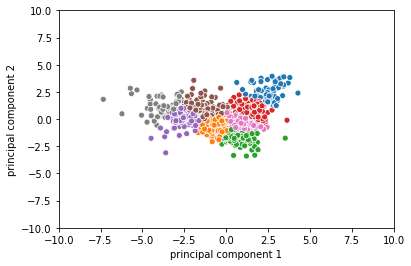

In [109]:
plt.figure()
plt.ylim(-10, 10)
plt.xlim(-10, 10)
sns.scatterplot(x='principal component 1', y ='principal component 2', hue ="Cluster", data = train_clustered, legend = False )


In [110]:
train_clustered.to_csv('train_players_clustered.csv')
test_clustered.to_csv('test_players_clustered.csv')
all_players_clustered.to_csv('all_players_clustered.csv')

In [111]:
all_players_clustered

,Player_x,Pos_x,Tm_x,3P%,2P%,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,ORtg,DRtg,Player_year,Year,TS%,3PAr,FTr,OWS,DWS,Abrv,Team_full,principal component 1,principal component 2,Cluster,All-Star_caliber
0,Jordan Adams\adamsjo01,SG,MEM,0.000,0.400,0.600,0.0,6.9,6.9,10.3,10.3,0.0,6.9,84.0,90,Jordan Adams\adamsjo01/2016,2016,0.427,0.167,0.833,0.0,0.0,MEM,Memphis Grizzlies/2016,3.374690,2.152222,Primary Distributing Ballhandler,0
1,Tony Allen\allento01,SG,MEM,0.357,0.468,0.652,3.3,6.1,9.4,2.2,3.5,0.6,5.6,101.0,105,Tony Allen\allento01/2016,2016,0.505,0.090,0.294,0.5,1.9,MEM,Memphis Grizzlies/2016,-0.281585,-1.181646,Defensive Forward,0
2,Vince Carter\cartevi01,SG,MEM,0.349,0.425,0.833,1.6,5.9,7.5,2.9,1.9,0.8,5.2,107.0,108,Vince Carter\cartevi01/2016,2016,0.520,0.493,0.245,1.0,0.8,MEM,Memphis Grizzlies/2016,0.368797,-1.029163,3 & D Wing,0
3,Mike Conley\conlemi01,PG,MEM,0.363,0.449,0.834,0.8,4.0,4.8,10.0,2.0,0.5,2.9,115.0,110,Mike Conley\conlemi01/2016,2016,0.538,0.309,0.329,4.2,1.1,MEM,Memphis Grizzlies/2016,2.439728,1.714107,Primary Distributing Ballhandler,0
4,Jordan Farmar\farmajo01,PG,MEM,0.356,0.473,1.000,0.7,3.7,4.4,6.5,2.7,0.4,3.9,103.0,109,Jordan Farmar\farmajo01/2016,2016,0.527,0.450,0.100,0.2,0.2,MEM,Memphis Grizzlies/2016,2.046978,0.295611,Combo Guard,0
5,Marc Gasol\gasolma01,C,MEM,0.667,0.463,0.829,1.7,8.7,10.4,5.6,1.4,2.0,4.1,105.0,106,Marc Gasol\gasolma01/2016,2016,0.528,0.004,0.347,1.8,1.9,MEM,Memphis Grizzlies/2016,-0.150047,0.306579,Defensive Forward,0
6,JaMychal Green\greenja01,PF,MEM,0.333,0.478,0.752,4.9,8.3,13.3,2.4,1.6,1.2,6.7,105.0,107,JaMychal Green\greenja01/2016,2016,0.520,0.091,0.277,1.2,1.4,MEM,Memphis Grizzlies/2016,-1.543935,-0.209245,Offensive Big Man,0
7,Jarell Martin\martija01,PF,MEM,0.000,0.474,0.726,5.3,6.4,11.6,2.0,1.1,0.9,7.9,110.0,110,Jarell Martin\martija01/2016,2016,0.534,0.017,0.534,0.5,0.2,MEM,Memphis Grizzlies/2016,-1.856606,0.738950,Pace & Space Forward,0
8,Xavier Munford\munfoxa02,SG,MEM,0.391,0.426,0.500,0.6,5.9,6.5,4.6,2.7,0.6,5.3,92.0,107,Xavier Munford\munfoxa02/2016,2016,0.481,0.299,0.182,-0.2,0.2,MEM,Memphis Grizzlies/2016,1.330264,-0.296465,Slashing Guard,0
9,Zach Randolph\randoza01,PF,MEM,0.231,0.482,0.796,4.6,8.9,13.5,3.6,1.1,0.3,3.7,107.0,109,Zach Randolph\randoza01/2016,2016,0.519,0.029,0.238,2.8,1.5,MEM,Memphis Grizzlies/2016,-0.941344,0.000100,Defensive Forward,0
